In [23]:
import copy
import time
import matplotlib
matplotlib.use('pdf')
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np

%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision import transforms
import torch.optim as optim
import time
from tqdm import tqdm, trange

import loss_landscapes
import loss_landscapes.metrics
from loss_landscapes.model_interface.model_wrapper import ModelWrapper, wrap_model
from loss_landscapes.model_interface.model_parameters import ModelParameters, rand_u_like, rand_n_like, orthogonal_to
from loss_landscapes.contrib.functions import SimpleWarmupCaller, SimpleLossEvalCaller, log_refined_loss

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])
        
batch_size = 512

# download dataset
cifar_train = datasets.CIFAR10(root='/global/cfs/cdirs/m636/geshi/data', train=True, download=True, transform=transform_train)
cifar_test = datasets.CIFAR10(root='/global/cfs/cdirs/m636/geshi/data', train=False, download=True, transform=transform_test)
print(len(cifar_train), len(cifar_test))

# Load dataset
train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified
50000 10000


# Define ResNet

In [3]:
import sys
sys.path.append("/global/u2/g/geshi/PyHessian")

In [4]:
from utils import * # get the dataset
from pyhessian import hessian # Hessian computation
from models.resnet import resnet
from density_plot import get_esd_plot # ESD plot
from pytorchcv.model_provider import get_model as ptcv_get_model # model

In [5]:
# get the model 
model = resnet(num_classes=10,
               depth=20,
               residual_not=False,
               batch_norm_not=True)# change the model to eval mode to disable running stats upate

if torch.cuda.is_available():
    model = model.cuda()
model = torch.nn.DataParallel(model)

# create loss function
criterion = torch.nn.CrossEntropyLoss()

In [6]:
# stores the initial point in parameter space
model_initial = copy.deepcopy(model)

# Load pretrained ResNet

In [7]:
# PATH = '/global/u2/g/geshi/PyHessian/checkpoints/net.pkl'
# PATH = '/global/cfs/cdirs/m636/geniesse/ResNet20_models/resnet20_batch_norm_True_residual_False_seed_0_net.pkl'
PATH = '/global/cfs/cdirs/m636/geniesse/ResNet20_models/resnet20_batch_norm_True_residual_False_seed_0_net.pkl'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [8]:
def test_accuracy(test_loader, net):
    """Evaluate testset accuracy of a model."""
    net.eval()
    acc_sum, count = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            # send data to the GPU if cuda is availabel
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
            count += inputs.size(0)
            
            outputs = net(inputs)
            _, preds = torch.max(outputs, 1)

            # labels = labels.long()
            acc_sum += torch.sum(preds == labels.data).item()
    return acc_sum/count

In [9]:
since = time.time()
acc = test_accuracy(test_loader, model)
print('time cost ', time.time()-since)
print(acc)

time cost  7.305870532989502
0.9067


In [33]:
# contour plot resolution
STEPS = 10
DIST = 0.05

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_final = copy.deepcopy(model)

In [34]:
x, y = iter(train_loader).__next__()
metric = loss_landscapes.metrics.Loss(criterion, x.to(device), y.to(device))

# 2D loss landscape

In [35]:
model_start_wrapper = wrap_model(model_final)
start_point = model_start_wrapper.get_module_parameters()
dir_one = rand_n_like(start_point)
dir_two = orthogonal_to(dir_one, 'normal')

In [36]:
# compute loss data
pll = loss_landscapes.PlanarLossLandscape(model_final, STEPS, deepcopy_model=True)
# pll.random_plain(distance=DIST, normalization='layer', random='normal', centered=True)
# pll.interpolation(model_initial, model_initial)
pll.precomputed(dir_one, dir_two, distance=DIST, normalization='layer', centered=True)
pll.stats_initializer()

In [37]:
# single batch loss landscape
since = time.time()
pll.warm_up(metric)
print('warmup time cost ', time.time()-since)

since = time.time()
loss_data_fin = pll.compute(metric)
print('compute time cost ', time.time()-since)

warmup time cost  2.081477403640747
compute time cost  1.6962029933929443


In [40]:
loss_data_fin = log_refined_loss(loss_data_fin)

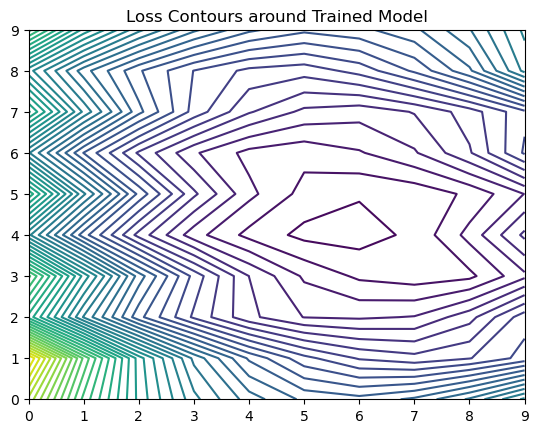

In [38]:
plt.contour(loss_data_fin, levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()

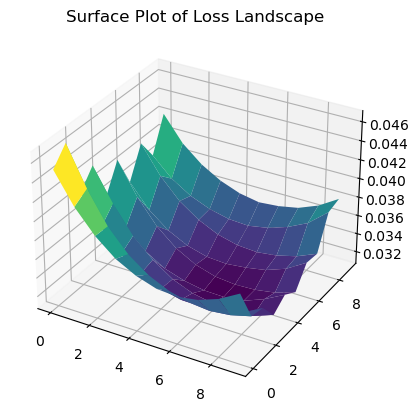

In [39]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

# Hessian eigenvector directions

In [46]:
hessian_comp = hessian(model,
                       criterion,
                       data=(x.to(device), y.to(device)),
                       cuda=True)

/global/homes/g/geshi/.conda/envs/CRF_GPU_Env/lib/python3.9/site-packages/torch/autograd/__init__.py:197: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/torch/csrc/autograd/engine.cpp:1059.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [47]:
print(
    '********** finish data londing and begin Hessian computation **********')

top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)
trace = hessian_comp.trace()
density_eigen, density_weight = hessian_comp.density()

print('\n***Top Eigenvalues: ', top_eigenvalues)
print('\n***Trace: ', np.mean(trace))

********** finish data londing and begin Hessian computation **********

***Top Eigenvalues:  [275.02301025390625, 233.6189727783203]

***Trace:  2572.4860636393228


In [48]:
dir_one = ModelParameters(top_eigenvector[0])
dir_two = ModelParameters(top_eigenvector[1])

In [49]:
### compute random projections and loss
pll = loss_landscapes.PlanarLossLandscape(model_start_wrapper, STEPS, deepcopy_model=True)
pll.precomputed(dir_one, dir_two, distance=DIST, normalization='layer', centered=True)
pll.stats_initializer()

In [50]:
# single batch loss landscape
since = time.time()
pll.warm_up(metric)
print('warmup time cost ', time.time()-since)

since = time.time()
loss_data_fin = pll.compute(metric)
print('compute time cost ', time.time()-since)

warmup time cost  1.3926780223846436
compute time cost  0.7583341598510742


In [51]:
loss_data_fin = log_refined_loss(loss_data_fin)

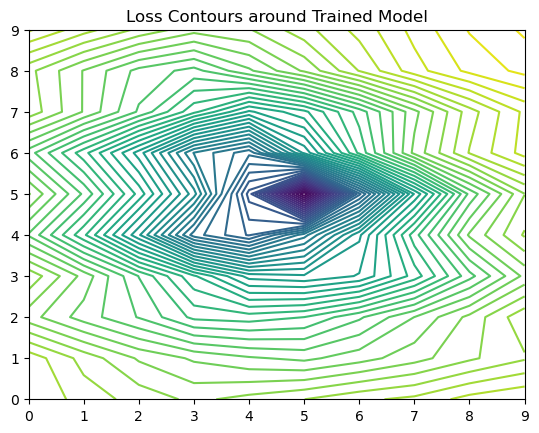

In [52]:
plt.contour(loss_data_fin, levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()

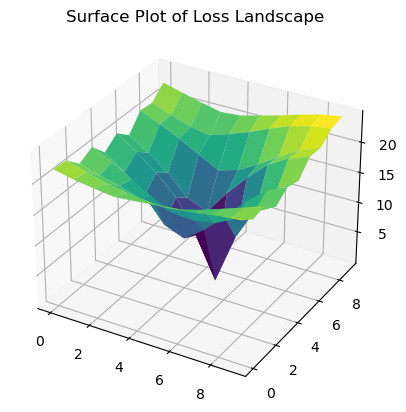

In [53]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()